# Import Libraries

In [2]:
from cdptools import CDPInstance, configs
import os, sys
import traceback
import json
import string
import pickle
from rake_nltk import Metric, Rake
import nltk
import pandas as pd
import numpy as np
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
import seaborn as sb
import spacy
from spacy import displacy
from collections import Counter
from gensim import corpora, models
import gensim
from nltk import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from itertools import combinations

# Initialize Things

In [3]:
nlp = spacy.load("en_core_web_sm")
stop_words=set(stopwords.words("english"))
tokenizer = RegexpTokenizer(r'\w+')
en_stop = set(stopwords.words('english'))
p_stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [4]:
def query_firebase_transcripts():
    # Instantiate seattle object from CDP
    seattle = CDPInstance(configs.SEATTLE)
    
    # Get transcripts table
    transcripts = pd.DataFrame(seattle.database.select_rows_as_list("transcript"))
    transcripts.head()
    
    # Get the other tables
    events = pd.DataFrame(seattle.database.select_rows_as_list("event"))
    bodies = pd.DataFrame(seattle.database.select_rows_as_list("body"))
    files = pd.DataFrame(seattle.database.select_rows_as_list("file"))

    # Merge the tables
    events = events.merge(bodies, left_on="body_id", right_on="body_id", suffixes=("_event", "_body"))
    transcripts = transcripts.merge(files, left_on="file_id", right_on="file_id", suffixes=("_transcript", "_file"))
    transcripts = transcripts.merge(events, left_on="event_id", right_on="event_id", suffixes=("_transcript", "_event"))
    transcripts.head()
    
    # modify filename to raw instead of ts_sentences for raw text body
    transcripts['raw_filename'] = transcripts['filename'].apply(lambda x: x.replace('ts_sentences','raw'))
    
    return transcripts

In [5]:
def get_file_text(raw_path):
    try:
        with open(raw_path, "r") as read_in:
            transcript = json.load(read_in)
        return transcript
    except Exception as e:
        print('-'*60)
        traceback.print_exc(file=sys.stdout)
        print('-'*60)
        return ''

In [6]:
def extract_keywords(text):
    # Extract keywords between 2 and 10 words long with ranked scores
    r = Rake(min_length=2, max_length=10)
    r.extract_keywords_from_text(text)
    ranked_phrases = r.get_ranked_phrases_with_scores()
    return ranked_phrases

# Query firebase DB for transcripts

In [7]:
transcripts = query_firebase_transcripts()

In [8]:
transcripts.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165 entries, 0 to 164
Data columns (total 23 columns):
transcript_id             165 non-null object
confidence                165 non-null float64
event_id                  165 non-null object
file_id                   165 non-null object
created_transcript        165 non-null datetime64[ns]
filename                  165 non-null object
description_transcript    0 non-null object
created_file              165 non-null datetime64[ns]
uri                       165 non-null object
content_type              0 non-null object
body_id                   165 non-null object
legistar_event_link       165 non-null object
source_uri                165 non-null object
legistar_event_id         165 non-null int64
event_datetime            165 non-null datetime64[ns]
agenda_file_uri           165 non-null object
minutes_file_uri          95 non-null object
video_uri                 165 non-null object
created_event             165 non-null datetime6

# Build consolidated dataframe of all events from json

In [9]:
consolidated_events = pd.DataFrame()
events_list = []

for i in range(len(transcripts)):
    try:
        filename = transcripts.iloc[i]['raw_filename']
        print(f'Processing file:\n{filename}')
        
        # Check local file structure if file already downloaded4
        # Request to have .download_file() save into a folder, not directory with .ipynb
        if filename not in os.listdir('./event_transcripts'):
            print('Downloading file from cloud storage')
            event_path = seattle.file_store.download_file(filename, save_dir='./event_transcripts')    
        else:
            print('Sourcing file from local storage')
            os.chdir('./event_transcripts')
            event_path = os.path.abspath(filename)
            os.chdir('..')
            
        # Use event path to create dataframe for this event
        event_object = get_file_text(event_path)
        event_text = event_object['data'][0]['text']
        event_dict = {
            'event_filename': transcripts.iloc[i]['raw_filename'],
            'event_subject': transcripts.iloc[i]['name'],
            'event_datetime': transcripts.iloc[i]['event_datetime'],
            'event_video_url': transcripts.iloc[i]['video_uri'],
            'event_text': event_text,
            'event_registar_url': transcripts.iloc[i]['legistar_event_link']
        }
        events_list.append(event_dict)
        # Concat this event into dataframe with all other events
#         consolidated_events = pd.concat([consolidated_events, event_df])
        consolidated_events = pd.DataFrame(events_list)
    except Exception as e:
        print('-'*60)
        traceback.print_exc(file=sys.stdout)
        print('-'*60)
        pass

Processing file:
0985c2571e2da7fd37cf2e5fc3535dc280ce9d42c886d37f41d966a800a840e8_raw_transcript_0.json
Sourcing file from local storage
Processing file:
7e729d2068c5babe6672565664e2c01176a51b759f913d30aab13bcb2cb771f6_raw_transcript_0.json
Sourcing file from local storage
Processing file:
19c59afa5b2e6bb5bded666c489f17d1e730ae02153e185d13af27d6e7a912ea_raw_transcript_0.json
Sourcing file from local storage
Processing file:
ce90894107a4e81431a190e2236ea213f07eb5622a15ce5f7c6c243f4726f256_raw_transcript_0.json
Sourcing file from local storage
Processing file:
cb5428b8f63b30578fcc78ed83e2e13b9186dfffe2367a0dd7f1b2da6eef919a_raw_transcript_0.json
Sourcing file from local storage
Processing file:
73339bcc49119a8778224ad17595397423692482e3a2bcc19266878b76dc8827_raw_transcript_0.json
Sourcing file from local storage
Processing file:
fb022f4a4b745bf6a249bc6e80ec2565919c245b83bed4dcdb8e32affbac5c15_raw_transcript_0.json
Sourcing file from local storage
Processing file:
24aa4fc8d90474b5819578d4

Processing file:
b9cd8fb5f368b1bf84691ac443ddb9f24220fdd4a968a849dbad7f8a70192e36_raw_transcript_0.json
Sourcing file from local storage
Processing file:
1c66a34487c1cca5af09f4324582b16ac248d382e98d6f66f9d4f47a999c21cf_raw_transcript_0.json
Sourcing file from local storage
Processing file:
23a1273bffc9f10c53778475d2d9789d1bd55ac36500b71cfea8bad6ce1da5de_raw_transcript_0.json
Sourcing file from local storage
Processing file:
ac4905a8fac590cf5dbcce0bc5860ed3a61ed20f40c932a229fabd3121c33a3c_raw_transcript_0.json
Sourcing file from local storage
Processing file:
dcf83bb51a4831b43e92c3e356e67b98aaa50196635a92d01f9132db2ccd0682_raw_transcript_0.json
Sourcing file from local storage
Processing file:
90e1206f85883dfa0daf00f4d715cfb7fa286747421a38ae271271f1a2b0fd42_raw_transcript_0.json
Sourcing file from local storage
Processing file:
e3c0d3397a70a06a2507a2c31761d3017824dcf8df5489fa63efd2b4144af2bf_raw_transcript_0.json
Sourcing file from local storage
Processing file:
32f00e1a22cf7ba79000a744

Processing file:
a6bb0e1f9a97450c483ad8648f2aa98f1c4d348b830d08ed96b283385bb3d270_raw_transcript_0.json
Sourcing file from local storage
Processing file:
e8d80518f82842c149de46fba8a703bf2cf9c6e4eb3c1bfffea1b40b943cc8a6_raw_transcript_0.json
Sourcing file from local storage
Processing file:
b0d394f1837ee56aae3664e8e665e806564b52953bfce0e98045a7dcc9c24f69_raw_transcript_0.json
Sourcing file from local storage
Processing file:
9b1846e43fe47b251c11367d414e6d065a518a95632a55a8f8c9a8f6d221663f_raw_transcript_0.json
Sourcing file from local storage
Processing file:
d26deb23a557168baa43e4859fa56e0ea8f86ced29090a097590adfed99cefb7_raw_transcript_0.json
Sourcing file from local storage
Processing file:
457b8e1148f5f9bf23d79018cfbfb3cc014b1affff0156f717029b9721861495_raw_transcript_0.json
Sourcing file from local storage
Processing file:
84c25fed0242514c2382f29bc9d857cc63b9e4c00faf8d8700b33afc67d3c830_raw_transcript_0.json
Sourcing file from local storage
Processing file:
a566e15cc7518aaffbe1dcf6

In [10]:
consolidated_events.head()


event_filename  \
0  0985c2571e2da7fd37cf2e5fc3535dc280ce9d42c886d3...   
1  7e729d2068c5babe6672565664e2c01176a51b759f913d...   
2  19c59afa5b2e6bb5bded666c489f17d1e730ae02153e18...   
3  ce90894107a4e81431a190e2236ea213f07eb5622a15ce...   
4  cb5428b8f63b30578fcc78ed83e2e13b9186dfffe2367a...   

                                       event_subject      event_datetime  \
0  Housing, Health, Energy, and Workers’ Rights C... 2019-05-02 09:30:00   
1                Finance and Neighborhoods Committee 2019-04-24 14:00:00   
2                                       City Council 2019-04-17 17:30:00   
3  Gender Equity, Safe Communities, New Americans... 2019-07-31 09:30:00   
4  Civil Rights, Utilities, Economic Development,... 2019-07-09 09:30:00   

                                     event_video_url  \
0  https://video.seattle.gov/media/council/hous_0...   
1  https://video.seattle.gov/media/council/fin_04...   
2  https://video.seattle.gov/media/council/counci...   
3  https://video.seattle.gov/media/council/gendeq...   
4  https://video.seattle.gov/media/council/civ_07...   

                                          event_text  \
0  Good morning. Everyone. Today is Thursday May ...   
1  Hi, good afternoon, everybody and welcome to o...   
2  Good afternoon, everybody. Thank you for being...   
3  The big transition. All right. Good morning. T...   
4  Good morning, and welcome to the July 9th meet...   

                                  event_registar_url  
0  https://seattle.legistar.com/MeetingDetail.asp...  
1  https://seattle.legistar.com/MeetingDetail.asp...  
2  https://seattle.legistar.com/MeetingDetail.asp...  
3  https://seattle.legistar.com/MeetingDetail.asp...  
4  https://seattle.legistar.com/MeetingDetail.asp...

In [11]:
consolidated_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164 entries, 0 to 163
Data columns (total 6 columns):
event_filename        164 non-null object
event_subject         164 non-null object
event_datetime        164 non-null datetime64[ns]
event_video_url       164 non-null object
event_text            164 non-null object
event_registar_url    164 non-null object
dtypes: datetime64[ns](1), object(5)
memory usage: 7.8+ KB


# Sample phrase extraction from frequency and RAKE

In [15]:
consolidated_events['raked_keywords'] = consolidated_events['event_text'].apply(lambda x: extract_keywords(x))

In [24]:
text_tokens = nltk.word_tokenize(consolidated_events.iloc[0]['event_text'].translate(str.maketrans('', '', string.punctuation)))
filtered_tokens = []
for word in text_tokens:
    if word not in stop_words and len(word) > 2:
        filtered_tokens.append(lemmatizer.lemmatize(word.lower()))
phrase_frequency = FreqDist(filtered_tokens)
phrase_frequency

FreqDist({'really': 115, 'thank': 96, 'know': 95, 'people': 93, 'think': 87, 'would': 78, 'work': 76, 'thats': 71, 'housing': 71, 'want': 66, ...})

In [35]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5

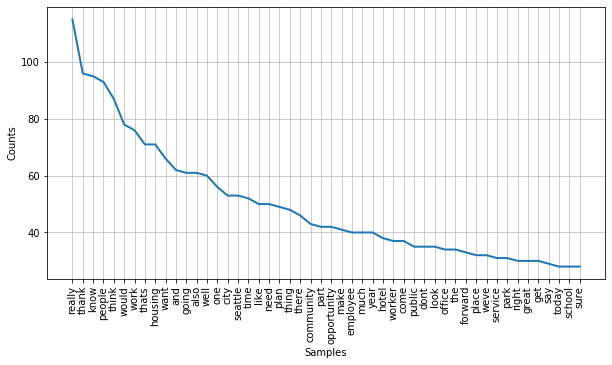

In [36]:
phrase_frequency.plot(50,cumulative=False)
plt.show()

In [38]:
test_sentences = nltk.sent_tokenize(consolidated_events.iloc[0]['event_text'])

In [69]:
relevant_phrases = []
for sentence in test_sentences:
    word_tokens = nltk.word_tokenize(sentence)
    print(word_tokens)
    if len(word_tokens) > 2:
        raked_phrases = extract_keywords(sentence)
        for phrase in phrases:
            print(f'""{phrase[1]}"" has score: {phrase[0]}')
            if phrase[0] >= 5.0:
                relevant_phrases.append(phrase)

['Good', 'morning', '.']
<class 'nltk.probability.FreqDist'>
""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['Everyone', '.']
['Today', 'is', 'Thursday', 'May', '2nd', 'soon', 'be', 'joined', 'by', 'a', 'chair', 'of', 'the', 'committee', 'as', 'the', 'Director', 'of', 'the', 'office', 'of', 'the', 'employee', 'on', 'but', 'sodium', 'on', 'but', 'as', 'hoteliers', 'are', 'going', 'to', 'be', 'here', 'in', 'our', 'first', 'freezing', 'of', 'the', 'Fort', 'Lawton', 'Redevelopment', 'plans', 'of', 'The', 'Pact', 'agenda', '.']
<class 'nltk.probability.FreqDist'>
""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['Also', ',', 'very', 'excited', 'to', 'see', 'a', 'packed', 'audience', 'today', '.']
<class 'nltk.probability.FreqDist'>
""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['Thank', 'you', 'all', 'so', 'much', 'for', 'being', 'here', 'before', 'the', 'public', 'comment', '.']
<class 'nltk.probabilit

""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['So', 'while', 'you', "'re", 'sitting', 'with', 'the', 'city', 'council', 'members', 'and', 'members', 'of', 'the', 'executive', 'team', ',', 'can', 'you', 'talk', 'a', 'little', 'bit', 'more', 'about', 'how', 'you', "'ll", 'help', 'to', 'ensure', 'that', 'the', 'workers', 'across', 'the', 'city', 'understand', 'that', 'you', 'know', ',', 'this', 'is', 'not', 'going', 'to', 'be', 'overseen', 'by', 'any', 'sort', 'of', 'political', 'influence', '.']
<class 'nltk.probability.FreqDist'>
""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['This', 'is', 'truly', 'a', 'body', 'that', 'you', 'will', 'have', 'on', 'Direction', 'on', 'what', 'what', "'s", 'your', 'vision', 'for', 'how', 'I', 'tell', 'you', 'both', 'run', 'that', 'and', 'communicate', 'that', 'I', 'think', 'communicating', 'how', 'the', 'how', 'the', 'office', 'is', 'going', 'to', 'function', 'and', 'what', 'kind', 'of', 'serv

""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['So', 'we', 'have', 'elected', 'people', 'or', 'when', 'we', 'have', 'processes', 'in', 'place', 'to', 'address', 'the', 'safety', 'of', 'our', 'colleagues', 'at', 'all', 'times', '.']
<class 'nltk.probability.FreqDist'>
""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['I', 'do', "n't", 'know', 'if', 'I', 'Specific', 'for', 'my', 'hotel', ',', 'I', 'would', 'not', 'have', 'seen', 'that', 'change', 'in', 'behavior', '.']
<class 'nltk.probability.FreqDist'>
""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['That', 'is', 'a', 'lot', 'of', 'our', 'guests', 'are', 'international', 'are', 'there', 'traveling', 'from', 'other', 'states', '?']
<class 'nltk.probability.FreqDist'>
""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['They', "'re", 'not', 'very', 'familiar', 'with', 'the', 'law', '.']
<class 'nltk.probability.FreqDist'>
""

<class 'nltk.probability.FreqDist'>
""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['Do', "n't", 'know', 'welcome', 'back', 'to', 'the', 'table', 'to', 'be', 'here', '.']
<class 'nltk.probability.FreqDist'>
""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['Once', 'again', ',', 'I', 'want', 'to', 'thank', 'the', 'council', 'and', 'our', 'partners', 'in', 'the', 'office', 'of', 'Housing', 'and', 'Seattle', 'Parks', 'and', 'Recreation', 'for', 'working', 'with', 'us', '.']
<class 'nltk.probability.FreqDist'>
""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['The', 'district', 'is', 'like', 'everyone', 'else', 'to', 'table', 'it', 'has', 'to', 'develop', 'property', 'is', 'thankful', 'to', 'be', 'able', 'to', 'participate', 'in', 'the', 'potential', 'opportunity', 'like', 'this', '.']
<class 'nltk.probability.FreqDist'>
""tremendous looking forward"" has score: 9.0
""finish line"" has score: 4.0
['We', '

In [65]:
relevant_phrases

[(16.0, 'thursday may 2nd soon'),
 (16.0, 'fort lawton redevelopment plans'),
 (9.0, 'packed audience today'),
 (25.0, 'international workers day around solid'),
 (9.0, 'sharing right outside'),
 (9.0, 'called solidarity forever'),
 (25.0, 'union makes us stronger walter'),
 (16.0, 'teaching walters lifelong interest'),
 (15.5, 'compton unified school district'),
 (9.0, 'started use info'),
 (9.0, 'school photography program'),
 (9.0, 'california teachers association'),
 (9.0, 'empower urban youth'),
 (9.0, 'bad court decisions'),
 (9.0, 'stepson dmitri iglitzin'),
 (9.0, 'somebody know dimitri'),
 (9.0, 'maybe take portraits'),
 (9.0, 'display right outside'),
 (35.0, 'found longshoreman unloading ships cargo ones'),
 (17.0, 'found mechanics assembling airplanes'),
 (16.0, 'microsoft software would work'),
 (9.0, 'found truck drivers'),
 (9.0, 'amazon customers leaving'),
 (9.0, 'like letter carriers'),
 (9.0, 'helping us get'),
 (8.5, 'help labor activists'),
 (9.0, 'future right out

# Text preprocessing for event bodies

In [12]:
def process_event(bodies=None, tfidf=False):
    bodies = [body.lower().split('.') for body in bodies if isinstance(body, str)]
    
    # flatten the list of lists of paragraphs
    bodies = [x for y in bodies for x in y]
#     bodies = [' '.join(body.split(delimiter+'|/t')) for body in bodies if isinstance(body, str)]
    
    # tokenize the paragraphs
    bodies = [tokenizer.tokenize(x) for x in bodies]
    
    # use paragraphs > 5 tokens long, remove empty blocks
    bodies = [body for body in bodies if len(body) > 5]
    
    # remove stop words and numbers, 1-len words
    bodies = [[b for b in body if (b not in en_stop and not b.isdigit() and len(b) > 1)] for body in bodies]
    
    # lemmatize
    bodies = [[lemmatizer.lemmatize(b) for b in body] for body in bodies]
    
    # join documents separated by ' ' for TFIDF/NMF
    if tfidf:
        bodies = [" ".join(doc) for doc in bodies]
    
    return bodies

In [13]:
def process_event_for_lda(text):
    text = text.lower().split(".")
    # tokenize the paragraphs
    text = [tokenizer.tokenize(par) for par in text]
    # use paragraphs > 5 tokens long, remove empty blocks
    text = [par for par in text if len(par) > 5]
    # stop words
    text = [[w for w in par if (w not in en_stop and not w.isdigit() and len(w) > 1)] for par in text]
    # lemmatize
    text = [[lemmatizer.lemmatize(w) for w in par] for par in text]
    text = [dictionary.doc2bow(par) for par in text]
    return text

In [14]:
text_bodies = consolidated_events['event_text'].to_list()
processed_bodies = process_event(text_bodies)

In [15]:
processed_bodies

[['today',
  'thursday',
  'may',
  '2nd',
  'soon',
  'joined',
  'chair',
  'committee',
  'director',
  'office',
  'employee',
  'sodium',
  'hotelier',
  'going',
  'first',
  'freezing',
  'fort',
  'lawton',
  'redevelopment',
  'plan',
  'pact',
  'agenda'],
 ['also', 'excited', 'see', 'packed', 'audience', 'today'],
 ['thank', 'much', 'public', 'comment'],
 ['like',
  'take',
  'quick',
  'moment',
  'recognize',
  'yesterday',
  'international',
  'worker',
  'day',
  'around',
  'solid'],
 ['would', 'like', 'quick', 'second', 'invite', 'walter'],
 ['thank',
  'walter',
  'sheriff',
  'work',
  'u',
  'exhibit',
  'sharing',
  'right',
  'outside',
  'city',
  'hall'],
 ['see', 'pillar', 'called', 'solidarity', 'forever'],
 ['union',
  'make',
  'u',
  'stronger',
  'walter',
  'active',
  'member',
  'california',
  'teacher',
  'association',
  'participated',
  'month',
  'long',
  'strike',
  'member',
  'cta',
  'compton',
  'unified',
  'school',
  'district',
  'retiri

# Build Corpus dictionary from preprocessed event text

In [69]:
# create the dictionary and corpus
dictionary = corpora.Dictionary(processed_bodies)
# filter rares and very common words from the dictionary 
dictionary.filter_extremes(no_below=20, no_above=0.6)
corpus = [dictionary.doc2bow(body) for body in processed_bodies]

# Train Gensim LDA Model

In [132]:
# create the LDA model
TOPICS = 10
PASSES = 20
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=TOPICS, id2word = dictionary, passes=PASSES)

In [133]:
ldamodel.print_topics(num_topics=30, num_words=30)

[(0,
  '0.049*"thank" + 0.045*"little" + 0.031*"bit" + 0.029*"much" + 0.017*"keep" + 0.014*"talk" + 0.014*"u" + 0.013*"want" + 0.013*"light" + 0.013*"design" + 0.012*"street" + 0.011*"going" + 0.010*"well" + 0.009*"get" + 0.008*"guy" + 0.008*"quickly" + 0.008*"coming" + 0.008*"word" + 0.007*"work" + 0.007*"time" + 0.007*"yes" + 0.007*"parking" + 0.007*"stuff" + 0.006*"see" + 0.006*"car" + 0.006*"today" + 0.006*"avenue" + 0.006*"focusing" + 0.006*"project" + 0.005*"close"'),
 (1,
  '0.036*"service" + 0.023*"violence" + 0.017*"provider" + 0.016*"central" + 0.016*"staff" + 0.013*"pay" + 0.012*"human" + 0.011*"system" + 0.011*"board" + 0.011*"data" + 0.011*"household" + 0.009*"contract" + 0.008*"seattle" + 0.008*"name" + 0.007*"american" + 0.007*"house" + 0.007*"city" + 0.007*"case" + 0.006*"race" + 0.006*"evaluation" + 0.006*"based" + 0.006*"control" + 0.006*"social" + 0.006*"progress" + 0.006*"teacher" + 0.006*"activity" + 0.006*"basically" + 0.005*"hall" + 0.005*"offer" + 0.005*"check"'

In [136]:
def get_topics(body, ldamodel):
    results = [ldamodel[par] for par in body]
    results = [[p for p in r if p[1] > .2] for r in results]
    return results

## Test output from LDA Model

In [137]:
test_event = process_event_for_lda(consolidated_events.iloc[0]['event_text'])
get_topics(test_event, ldamodel)

[[(8, 0.5310262)],
 [(5, 0.71760106)],
 [(0, 0.42000028), (8, 0.41999245)],
 [(6, 0.55051297)],
 [(6, 0.40968508), (8, 0.4569528)],
 [(5, 0.40349403)],
 [(9, 0.81997114)],
 [(2, 0.20187268), (7, 0.33574468)],
 [(7, 0.8046498)],
 [(0, 0.5315594)],
 [(8, 0.39682677), (9, 0.3287434)],
 [(5, 0.715838)],
 [(5, 0.60076165)],
 [(2, 0.28264278), (9, 0.6506747)],
 [(2, 0.3858826), (5, 0.56965894)],
 [(2, 0.24484718), (5, 0.41299984)],
 [(2, 0.22130054), (5, 0.25398445), (7, 0.28375873)],
 [(4, 0.2027229), (9, 0.21022081)],
 [(4, 0.59848726), (5, 0.22720128)],
 [(3, 0.45743972), (4, 0.23732844)],
 [(3, 0.29997385), (5, 0.3077469), (6, 0.2922599)],
 [(2, 0.41691843), (7, 0.29449603)],
 [(6, 0.4199655), (7, 0.41999578)],
 [(1, 0.23331195), (6, 0.677772)],
 [(0, 0.4200648), (1, 0.2199208), (7, 0.21998698)],
 [(0, 0.21999992), (8, 0.61999303)],
 [(0, 0.50029755), (6, 0.29967254)],
 [(6, 0.30535552), (8, 0.3007876)],
 [(0, 0.3556853), (5, 0.51093745)],
 [(4, 0.28274542), (8, 0.6029479)],
 [(8, 0.6833

# Preprocessed corpus of event bodies

In [16]:
def process_docs(documents):
    documents = documents.tolist()
#     documents = [re.sub("<http.*?>|www.*?.com|goo.gl", "__URL__", x, flags=re.I) for x in documents]
#     documents = [re.sub("http|com", "", x, flags=re.I) for x in documents]
    documents = [doc.lower() for doc in documents if isinstance(doc, str)]
    documents = [tokenizer.tokenize(doc) for doc in documents]
    documents = [[d for d in doc if (d not in en_stop and not d.isdigit() and len(d) > 1)] for doc in documents]
    documents = [[lemmatizer.lemmatize(d) for d in doc] for doc in documents]
    documents = [" ".join(doc) for doc in documents] 
    return documents

In [17]:
processed_bodies = process_docs(consolidated_events['event_text'])

In [18]:
processed_bodies

['good morning everyone today thursday may 2nd soon joined chair committee director office employee sodium hotelier going first freezing fort lawton redevelopment plan pact agenda also excited see packed audience today thank much public comment like take quick moment recognize yesterday international worker day around solid would like quick second invite walter thank walter sheriff work u exhibit sharing right outside city hall see pillar called solidarity forever union make u stronger walter active member california teacher association participated month long strike member cta compton unified school district retiring teaching walter lifelong interest photography intensified started use info focus seattle school photography program mission nonprofit work empower urban youth photography experience world new way focus positive choice awarded taller word president clinton department art humanity walter u talk little bit display think exciting full month may honor worker month double check

# Training NMF Topic Model with TFIDF on Corpus

In [20]:
vectorizer_doc = TfidfVectorizer(
    min_df=50,
    max_df=4000,
    max_features=1000)

vectorizer_doc.fit(processed_bodies)
tfidf_doc = vectorizer_doc.transform(processed_bodies)
tfidf_feature_names_doc = vectorizer_doc.get_feature_names()

nmf = NMF(n_components=15, random_state=1, alpha=.2, l1_ratio=.25, init='nndsvd').fit(tfidf_doc)
W = nmf.transform(tfidf_doc) # docs x topics (basis vectors); not a probability distribution
H = nmf.components_ # topics x term weights (coefficients)

# Display top words per topic
idx_to_word = np.array(vectorizer_doc.get_feature_names())
print('Topics found via TFIDF + NMF:')
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i, (", ".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]]))))

Topics found via TFIDF + NMF:
Topic 0: also, like, would, city, work, going, one, really, think, know
Topic 1: member, session, please, seattle, thank, bill, appointment, city, committee, council
Topic 2: program, access, amendment, service, hour, fine, material, book, levy, library
Topic 3: family, city, income, developer, home, displacement, thank, unit, affordable, housing
Topic 4: university, major, neighborhood, appointment, board, planning, public, commission, review, design
Topic 5: dollar, funding, food, money, million, program, fund, budget, revenue, tax
Topic 6: program, public, okay, appointment, board, seattle, thank, disability, recreation, park
Topic 7: labor, initiative, room, legislation, industry, thank, business, employer, employee, worker
Topic 8: team, data, homeless, village, permanent, service, housing, homelessness, people, shelter
Topic 9: people, bus, transportation, project, car, pedestrian, street, parking, lane, bike
Topic 10: need, like, senior, right, cont

In [21]:
all_topics = []
for i, topic in enumerate(H):
    topic_phrases = []
    topic_phrases.append([str(x) for x in idx_to_word[topic.argsort()[-10:]]])
    all_topics.append(topic_phrases)

In [22]:
all_topics

[[['also',
   'like',
   'would',
   'city',
   'work',
   'going',
   'one',
   'really',
   'think',
   'know']],
 [['member',
   'session',
   'please',
   'seattle',
   'thank',
   'bill',
   'appointment',
   'city',
   'committee',
   'council']],
 [['program',
   'access',
   'amendment',
   'service',
   'hour',
   'fine',
   'material',
   'book',
   'levy',
   'library']],
 [['family',
   'city',
   'income',
   'developer',
   'home',
   'displacement',
   'thank',
   'unit',
   'affordable',
   'housing']],
 [['university',
   'major',
   'neighborhood',
   'appointment',
   'board',
   'planning',
   'public',
   'commission',
   'review',
   'design']],
 [['dollar',
   'funding',
   'food',
   'money',
   'million',
   'program',
   'fund',
   'budget',
   'revenue',
   'tax']],
 [['program',
   'public',
   'okay',
   'appointment',
   'board',
   'seattle',
   'thank',
   'disability',
   'recreation',
   'park']],
 [['labor',
   'initiative',
   'room',
   'legislation

## Save the model to disk

In [23]:
model_filename = 'nmf_topic_model.pkl'

# Create an variable to pickle and open it in write mode
model_pickle = open(model_filename, 'wb')
pickle.dump(nmf, model_pickle)
model_pickle.close()

# Training NMF Topic Model on Single Document

In [147]:
[processed_bodies[0]]

['good morning everyone today thursday may 2nd soon joined chair committee director office employee sodium hotelier going first freezing fort lawton redevelopment plan pact agenda also excited see packed audience today thank much public comment like take quick moment recognize yesterday international worker day around solid would like quick second invite walter thank walter sheriff work u exhibit sharing right outside city hall see pillar called solidarity forever union make u stronger walter active member california teacher association participated month long strike member cta compton unified school district retiring teaching walter lifelong interest photography intensified started use info focus seattle school photography program mission nonprofit work empower urban youth photography experience world new way focus positive choice awarded taller word president clinton department art humanity walter u talk little bit display think exciting full month may honor worker month double check

In [160]:
vectorizer_doc = TfidfVectorizer()

tfidf_doc = vectorizer_doc.fit_transform([processed_bodies[0],processed_bodies[0],processed_bodies[0],processed_bodies[0],processed_bodies[0]])
tfidf_feature_names_doc = vectorizer_doc.get_feature_names()

nmf = NMF(n_components=1, random_state=42, alpha=.01, l1_ratio=.25).fit(tfidf_doc)
W = nmf.transform(tfidf_doc) # docs x topics (basis vectors); not a probability distribution
H = nmf.components_ # topics x term weights (coefficients)

# Display top words per topic
idx_to_word = np.array(vectorizer_doc.get_feature_names())
print('Topics found via TFIDF + NMF:')
for i, topic in enumerate(H):
    print("Topic {}: {}".format(i, (", ".join([str(x) for x in idx_to_word[topic.argsort()[-10:]]]))))

Topics found via TFIDF + NMF:
Topic 0: also, want, housing, work, would, think, people, know, thank, really


# Testing Non-Gensim LDA model

In [112]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

In [126]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}: {}".format(topic_idx, " ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]])))

In [117]:
count_vectorizer = CountVectorizer(stop_words='english')
count_data = count_vectorizer.fit_transform(processed_bodies)

In [131]:
number_topics = 10
number_words = 10

# Create and fit the LDA model
lda = LDA(n_components=number_topics)
lda.fit(count_data)

# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:
Topic 0: know really people think like work going city want seattle
Topic 1: city people year think thank library housing know seattle want
Topic 2: think community station know going work really process group like
Topic 3: know community want going need rent central people city thank
Topic 4: enactment budapest payton eaton dispersement improviser scoped latched outfall booking
Topic 5: enactment budapest payton eaton dispersement improviser scoped latched outfall booking
Topic 6: city council thank think work going community seattle really want
Topic 7: people housing know shelter service homelessness like want time homeless
Topic 8: know really community violence going police think like work seattle
Topic 9: hotel worker think business work thank want employee time know
